### Utility function
adapted from `PyLCM_edu.ipynb`

In [99]:
def create_results_dict(
        input
    ):
    """ Returns results as a dictionary, to make it easier to compare between runs. """

    nt, dt, time_array, T_parcel_array, P_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, wp_parcel_array, \
    qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, \
    spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, particles_array, \
    rc_liq_avg_array, rc_liq_std_array, TAU_ts_array, albedo_array = input

    results = {
        'nt': nt, 'dt': dt, 'time': time_array, 'T_parcel': T_parcel_array, 'P_parcel': P_parcel_array, 'RH_parcel': RH_parcel_array, 'q_parcel': q_parcel_array, 'z_parcel': z_parcel_array, 'wp_parcel': wp_parcel_array,
        'qa': qa_ts, 'qc': qc_ts, 'qr': qr_ts, 'na': na_ts, 'nc': nc_ts, 'nr': nr_ts,
        'spectra': spectra_arr, 'con': con_ts, 'act': act_ts, 'evp': evp_ts, 'dea': dea_ts, 'acc': acc_ts, 'aut': aut_ts, 'precip': precip_ts, 'particles': particles_array,
        'rc_liq_avg': rc_liq_avg_array, 'rc_liq_std': rc_liq_std_array, 'tau': TAU_ts_array, 'albedo': albedo_array
    }
    
    return results

### Setup model

In [100]:
# Import necessary modules
from PyLCM.animation import *
from PyLCM.widget import *
from PyLCM.timestep_routine import *
from PyLCM.parameters import *
# Import user modifiable modules
from Post_process.analysis import *
from Post_process.print_plot import *

# Uncomment lines below when changing source files
#######################
%load_ext autoreload
%autoreload 2
#######################

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
def make_run(mode,facN):
    # Model steering parameters

    dt                  = 1 # s
    nt                  = 10000
    do_condensation     = True
    do_collision        = True # should probably be False
    switch_sedi_removal = False
    n_particles         = 500
    max_z               = 1400 # m


    # Parcel initial parameters

    T_parcel        = 289.27 # K
    P_parcel        = 101181 # Pa
    RH_parcel       = 0.83
    w_parcel        = .2 # m s-1
    z_parcel        = 0 # m
    ascending_mode  = mode # linear / sine / in_cloud_oscillation / turbulent

    # Entrainment parameters

    switch_entrainment  = False
    stability           = 'Stable' # Stable / Unstable / Neutral
    entrainment_start   = 1000 # s
    entrainment_end     = 1030 # s
    entrainment_rate    = 0.05

    # Even if you are not using entrainment, you need to calculate these
    qv_init = RH_parcel * esatw( T_parcel ) / ( P_parcel - RH_parcel * esatw( T_parcel ) ) * r_a / rv
    qv_profiles, theta_profiles, z_env = create_env_profiles(T_parcel, qv_init, z_parcel, P_parcel, stability)


    # Koehler theory

    kohler_activation_radius    = True
    switch_kappa_koehler        = False
    mode_aero_init              = 'Random' # Random / Weighting_factor


    # Initialisation parameters for aerosol (up to 4 modes)
    # N_aero = number of aerosol per cm3 of air | mu = mean droplet radius | sigma = std. of mu | kappa = hygroscopicity parameter

    N_aero, mu_aero, sigma_aero, k_aero = [0]*4,[0]*4,[0]*4,[0]*4

    # Mode #1 ()
    N_aero[0]       = 100e6*facN # N_aero (m-3)
    mu_aero[0]      = 0.1e-6 # mu (m)
    sigma_aero[0]   = 2. # sigma (-)
    k_aero[0]       = 1.0 # kappa

    # Display mode

    display_mode = 'text_fast' # text_fast / graphics

    run \
    = create_results_dict(timesteps_function(
        dt, nt, do_condensation, do_collision, n_particles, \
        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, max_z, \
        rm_spec, ascending_mode, display_mode, \
        mode_aero_init, N_aero, mu_aero, sigma_aero, k_aero, \
        kohler_activation_radius, switch_kappa_koehler, switch_sedi_removal, \
        entrainment_rate, switch_entrainment, entrainment_start, entrainment_end,
        qv_profiles, theta_profiles
    ))
    return run

### Run model

In [119]:
linear_run = make_run('linear',1)
turbulent_run0 = make_run('turbulent',1)

value: Time (s) z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg) Comp. particles
after: 7000.0    1448.38  280.19   7.47      100.361   0.008     2.025     0.47      0.60      2.65      500     


In [103]:
turbulent_run = {"reference":turbulent_run0,
                "0.001%":make_run('turbulent',1+1e-5),
                "0.01%":make_run('turbulent',1+1e-4),
                "0.1%":make_run('turbulent',1+1e-3),
                "1%":make_run('turbulent',1+1e-2),
                "10%":make_run('turbulent',1+1e-1)}

value: Time (s) z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg) Comp. particles
after: 7000.0    1409.30  280.42   7.53      100.130   0.273     1.697     112.55    38.66     1.37      500     


## Some checks

In [104]:
w_parcel=.2 # need to make this global or pass it somehow

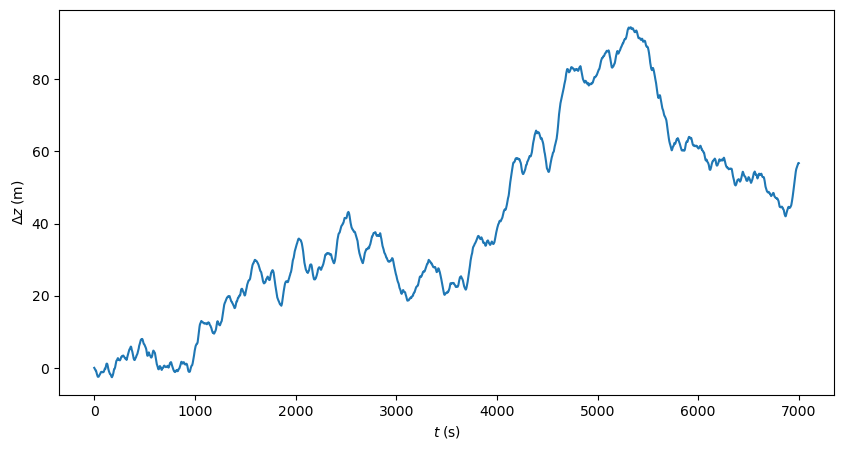

In [114]:
# plot elevation difference between linear and turbulent (reference)
fig, axs = plt.subplots(1, figsize=(10,5))

axs.plot(turbulent_run0['time'][0:],turbulent_run0['z_parcel'][0:]-turbulent_run0['time'][0:]*w_parcel)
axs.set_xlabel(r'$t\;$(s)')
axs.set_ylabel(r'$\Delta z\;$(m)')

plt.show()

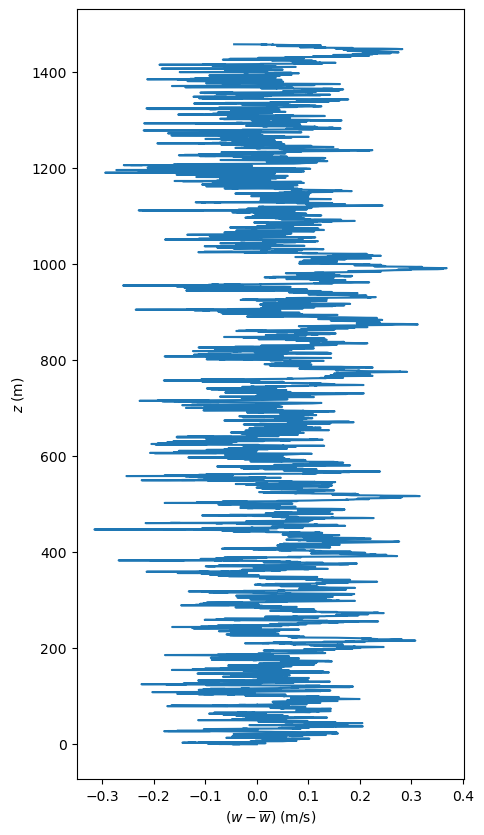

In [115]:
# plot turbulent updraft fluctuations (reference run)
fig, axs = plt.subplots(1, figsize=(5,10))

axs.plot(turbulent_run0['wp_parcel'][0:],turbulent_run0['z_parcel'][0:])
axs.set_xlabel(r"$\left(w-\overline{w}\right)\;$(m/s)")
axs.set_ylabel(r'$z\;$(m)')

plt.show()

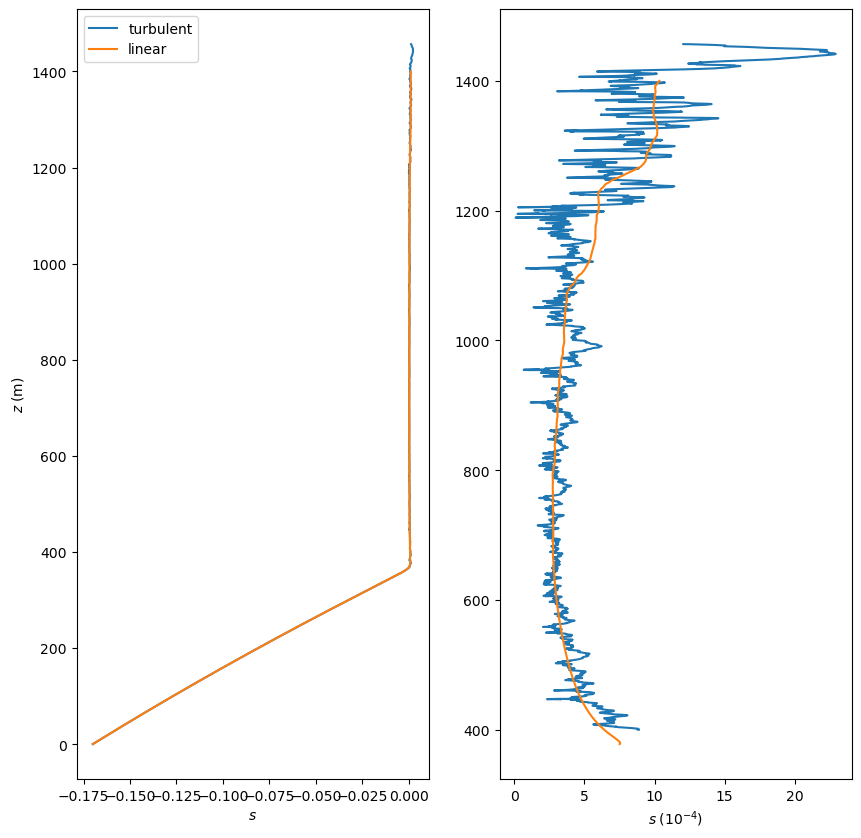

In [116]:
# Plot linear vs turbulent ascent (reference run)
fig, axs = plt.subplots(1,2,figsize=(10,10))

start_ind =0
axs[0].plot(turbulent_run0['RH_parcel'][start_ind:]-1,turbulent_run0['z_parcel'][start_ind:],label='turbulent')
axs[0].plot(linear_run['RH_parcel'][start_ind:]-1,linear_run['z_parcel'][start_ind:],label='linear')
axs[0].set_xlabel(r'$s$')
axs[0].set_ylabel(r'$z\;$(m)')
axs[0].legend()

height = 400 
start_ind = np.abs(turbulent_run0['z_parcel']-height).argmin()

axs[1].plot((turbulent_run0['RH_parcel'][start_ind:]-1)/1e-4,turbulent_run0['z_parcel'][start_ind:],label='turbulent')
axs[1].plot((linear_run['RH_parcel'][start_ind:]-1)/1e-4,linear_run['z_parcel'][start_ind:],label='linear')
axs[1].set_xlabel(r'$s\;(10^{-4})$')
#axs[1].set_ylabel(r'$z\;$(m)')

plt.show()

/var/folders/0r/wdb6kj5x1n58yrldpf8z0ph433jnct/T/ipykernel_86977/646491751.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax[0].contourf(1e6*rm_spec, turbulent_run0['z_parcel'], turbulent_run0['spectra'], norm=matplotlib.colors.LogNorm(), levels=np.logspace(6, 10, 5))
/var/folders/0r/wdb6kj5x1n58yrldpf8z0ph433jnct/T/ipykernel_86977/646491751.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax[1].contourf(1e6*rm_spec, linear_run['z_parcel'], linear_run['spectra'], norm=matplotlib.colors.LogNorm(), levels=np.logspace(6, 10, 5))


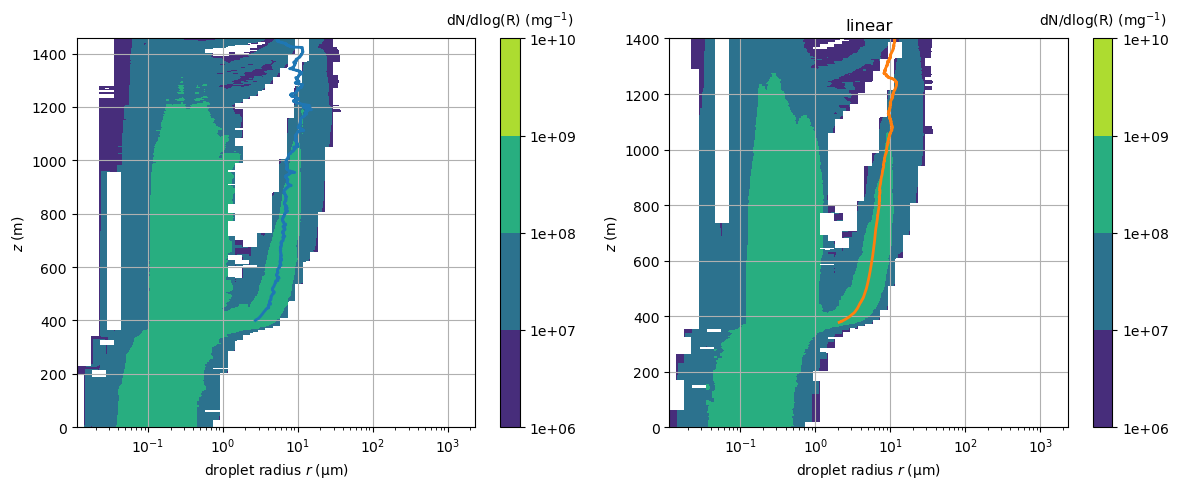

In [117]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

contour = ax[0].contourf(1e6*rm_spec, turbulent_run0['z_parcel'], turbulent_run0['spectra'], norm=matplotlib.colors.LogNorm(), levels=np.logspace(6, 10, 5))
cbar = plt.colorbar(contour, ax=ax[0], format="%.0e")
# Add cloud, rain mean droplet size above DSD
mean_turb,=ax[0].plot(turbulent_run0['rc_liq_avg'][start_ind:]*1e6,turbulent_run0['z_parcel'][start_ind:], linewidth=2, label='turbulent',color="C0")

ax[0].set_xlabel(r'droplet radius $r\;$(µm)')
ax[0].set_ylabel(r'$z\;$(m)')
cbar.ax.set_title(r'dN/dlog(R) (mg$^{-1}$)', fontsize = 10, pad = 10)
ax[0].set_xscale('log')
ax[0].grid()
ax[1].set_title("turbulent")

contour = ax[1].contourf(1e6*rm_spec, linear_run['z_parcel'], linear_run['spectra'], norm=matplotlib.colors.LogNorm(), levels=np.logspace(6, 10, 5))
cbar = plt.colorbar(contour, ax=ax[1], format="%.0e")
mean_lin,=ax[1].plot(linear_run['rc_liq_avg'][start_ind:]*1e6,linear_run['z_parcel'][start_ind:], linewidth=2, label='linear',color="C1")

ax[1].set_xlabel(r'droplet radius $r\;$(µm)')
ax[1].set_ylabel(r'$z\;$(m)')
cbar.ax.set_title(r'dN/dlog(R) (mg$^{-1}$)', fontsize = 10, pad = 10)
ax[1].set_xscale('log')
ax[1].grid()
ax[1].set_title("linear")

plt.tight_layout()
plt.show()

## Analysis

In [109]:
def compute_autocorrelation(x):
    """Compute the autocorrelation of a 1D array x."""
    
    n = len(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')#/ (np.var(x) * n) #np.correlate(x, x, mode='same')
    return result[result.size // 2:] #result


In [110]:
# define interval for computation (change this to be useful for all updrafts!!!)
low,high=800,1100 # height in m 
left,right=int(low/w_parcel),int(high/w_parcel)
labels=[run for run in turbulent_run]
acf_s = [[0]]*len(labels)
cum_acf_s = [0]*len(labels)
mean_s = [0]*len(labels)

for ind,label in enumerate(labels):
    selected = (turbulent_run[label]["RH_parcel"]-1)[left:right]
    

    acf_s[ind] = compute_autocorrelation(selected)
    cum_acf_s[ind] = np.sum(acf_s[ind])
    mean_s[ind] = selected.mean()

print(cum_acf_s)

[6.587939343037256e-06, 9.932118152757827e-06, 1.1781411815192883e-05, 1.0036602655226772e-05, 1.2897519463449573e-05, 1.0347508302323803e-05]


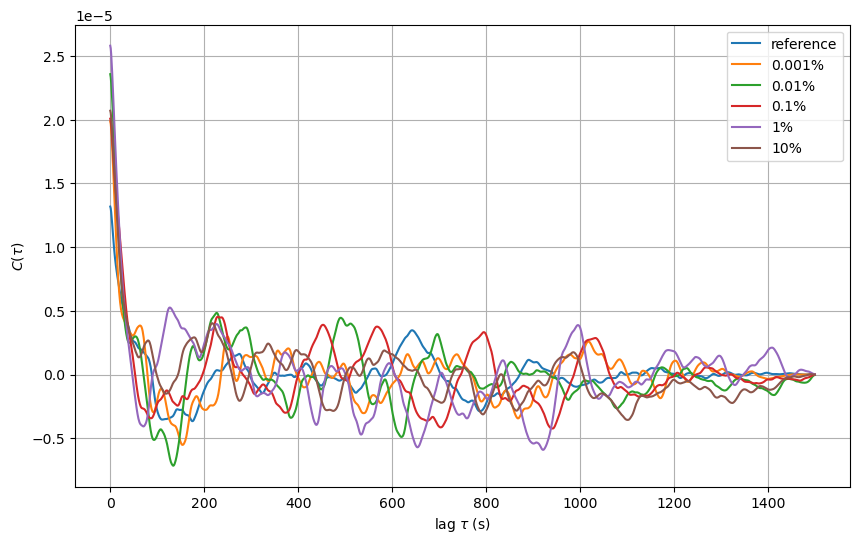

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, acf in enumerate(labels):
    ax.plot(acf_s[i], label=labels[i])

ax.set_xlabel(r'lag $\tau\;$(s)')
ax.set_ylabel(r'$C(\tau)$')
ax.legend()
ax.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (4,) and (5,)

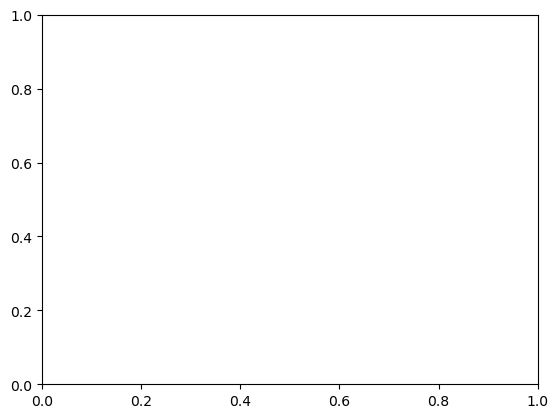

In [112]:
# still hacky, need more points
deltaN = np.array([300.03e6,300.3e6,303e6,330e6])-300e6
deltaS = np.array(mean_s[1:]-mean_s[0])

plt.plot(deltaN,deltaS,".")

In [522]:
from scipy.optimize import curve_fit

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def fit_exponential_to_autocorrelation(autocorr, lags):
    """
    Fit an exponential function to the autocorrelation data.
    
    Parameters:
    autocorr (numpy.ndarray): The autocorrelation values.
    lags (numpy.ndarray): The corresponding lags.
    
    Returns:
    popt (tuple): Optimal values for the parameters (a, b, c).
    pcov (2D array): The estimated covariance of popt.
    """
    # Initial guess for the parameters
    initial_guess = (1.0, 0.1, 0.0)
    
    # Fit the exponential function to the data
    popt, pcov = curve_fit(exponential_func, lags, autocorr, p0=initial_guess)
    
    return popt, pcov

# Example usage
autocorr = compute_autocorrelation(x)
lags = np.arange(len(autocorr))
popt, pcov = fit_exponential_to_autocorrelation(autocorr, lags)
print("Fitted parameters:", popt)


Fitted parameters: [ 9.95628101e+02  7.08839342e+00 -4.98895079e-01]


In [523]:
# integral of autocorrelation!

In [524]:
# steady state expected value of s (average)